# 描述
RankNet Demo
参看 https://github.com/eggie5/RankNet/blob/master/RankNet.ipynb#enroll-beta

In [1]:
import numpy as np

import keras
from keras import backend
from keras.layers import Activation, Add, Dense, Input, Lambda, Dropout, Subtract
from keras.models import Model, Sequential
from keras.utils import plot_model
%pylab inline

INPUT_DIM = 1536

Populating the interactive namespace from numpy and matplotlib


In [2]:
def create_base_network(input_dim):
    '''Base network to be shared (eq. to feature extraction).
    '''
    seq = Sequential()
    seq.add(Dense(INPUT_DIM, input_shape=(input_dim,), activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(64, activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(32, activation='relu'))
    seq.add(Dense(1))
    return seq

In [3]:
def create_meta_network(input_dim, base_network):
    input_a = Input(shape=(input_dim,))
    input_b = Input(shape=(input_dim,))

    rel_score = base_network(input_a)
    irr_score = base_network(input_b)

    # subtract scores
    diff = Subtract()([rel_score, irr_score])

    # Pass difference through sigmoid function.
    prob = Activation("sigmoid")(diff)

    # Build model.
    model = Model(inputs = [input_a, input_b], outputs = prob)
    model.compile(optimizer = "adam", loss = "binary_crossentropy")

    return model

In [5]:
base_network = create_base_network(INPUT_DIM)
model = create_meta_network(INPUT_DIM, base_network)
model.summary()

# plot_model(base_network, to_file='base.png')
# plot_model(model, to_file='meta.png')

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1536)]       0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1536)]       0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 1)            2461313     input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
subtract_1 (Subtract)           (None, 1)            0           sequential_1[0][0]         

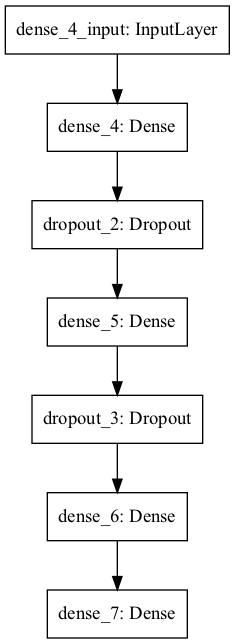

In [6]:
plot_model(base_network)


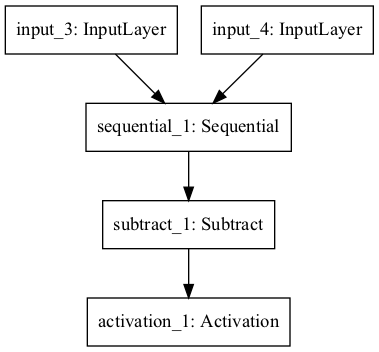

In [7]:
plot_model(model)

In [8]:
# Fake data.
N = 1000
SPLIT=750
X_1 = 2* np.random.randn(N, INPUT_DIM) # notice this data is shifted by 2
X_2 = np.random.randn(N, INPUT_DIM)

X_1_train = X_1[0:SPLIT,:]
X_1_test = X_1[SPLIT:N,:]

X_2_train = X_2[0:SPLIT,:]
X_2_test =  X_2[SPLIT:N,:]


y = np.ones((X_1.shape[0], 1))

y_train = y[0:SPLIT,:]
y_test = y[SPLIT:N,:]

np.mean(X_1_train), np.mean(X_2_train)

(0.0020105881781304394, 0.0005910986345732638)

In [9]:
# Train model.

es=keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=1, mode='auto')

NUM_EPOCHS = 10
BATCH_SIZE = 10
history = model.fit([X_1_train, X_2_train], y_train, 
                    validation_data=([X_1_test, X_2_test], y_test), 
                    batch_size = BATCH_SIZE, epochs = NUM_EPOCHS, verbose = 1, callbacks=[es])

Epoch 1/10
75/75 [==============================] - 2s 18ms/step - loss: 0.1975 - val_loss: 3.1189e-04
Epoch 2/10
75/75 [==============================] - 1s 10ms/step - loss: 8.0274e-04 - val_loss: 1.1276e-04
Epoch 3/10
75/75 [==============================] - 1s 8ms/step - loss: 2.6010e-04 - val_loss: 7.3773e-05
Epoch 4/10
75/75 [==============================] - 1s 9ms/step - loss: 1.8913e-04 - val_loss: 5.0565e-05
Epoch 5/10
75/75 [==============================] - 1s 8ms/step - loss: 8.3768e-05 - val_loss: 3.7844e-05
Epoch 6/10
75/75 [==============================] - 1s 7ms/step - loss: 5.9985e-05 - val_loss: 3.2870e-05
Epoch 7/10
75/75 [==============================] - 1s 11ms/step - loss: 2.6985e-05 - val_loss: 2.8985e-05
Epoch 8/10
75/75 [==============================] - 1s 9ms/step - loss: 5.2967e-05 - val_loss: 2.1997e-05
Epoch 9/10
75/75 [==============================] - 1s 11ms/step - loss: 1.1341e-04 - val_loss: 1.6683e-05
Epoch 10/10
75/75 [===========================

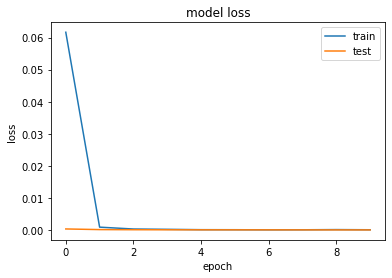

In [10]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [11]:
#the mean score of the high-rank distribution should be higher
np.mean(base_network.predict(X_1_test)), np.mean(base_network.predict(X_2_test))

(29.929232, 14.776619)

In [12]:
#AUC
(np.sum(base_network.predict(X_1_test) > base_network.predict(X_2_test))+0.0) / X_1_test.shape[0]


1.0